In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
import os
import sys
import glob
import requests
import yahist
from yahist import Hist1D
from scipy.integrate import odeint
import scipy.optimize
import scipy.stats
from tqdm.auto import tqdm

In [59]:
# relevant data and background for what the plots mean can be found here
# https://healthweather.us/

In [2]:
yahist.utils.set_default_style()

In [3]:
data_dir = "../sources/healthweather/data/"
state_abbrevs = list(map(lambda x:x.rsplit("/",1)[1].split("_",1)[0], glob.glob(f"{data_dir}/states/*.json")))

def get_df(state="CA"):
    js = json.load(open(f"{data_dir}/states/{state}_data.json"))
    dfc = pd.DataFrame(js["data"], columns=js["columns"])
    dfc["date"] = pd.to_datetime(dfc["date"])
    dfc = dfc.set_index("date")
    dfc["days_ago"] = -(dfc.index - pd.Timestamp.now()).total_seconds()/86400
    dfc["region_name"] = dfc["region_name"].str.replace(" County","",1)
    return dfc

dfc = get_df("CA")
dfc.head()

,region_id,region_name,state,observed_ili,atypical_ili,anomaly_diff,forecast_expected,forecast_lower,forecast_upper,days_ago
date,,,,,,,,,,
2020-03-02,06001,Alameda,CA,5.368277,NaN,0.000000,5.498323,4.724369,6.272277,22.704529
2020-03-03,06001,Alameda,CA,5.610915,NaN,0.000000,5.309133,4.535179,6.083087,21.704529
2020-03-04,06001,Alameda,CA,5.559394,NaN,0.000000,5.286651,4.512697,6.060605,20.704529
2020-03-05,06001,Alameda,CA,5.905835,NaN,0.000000,5.199360,4.425406,5.973314,19.704529
2020-03-06,06001,Alameda,CA,5.997299,5.997299,0.050551,5.172794,4.398840,5.946748,18.704529


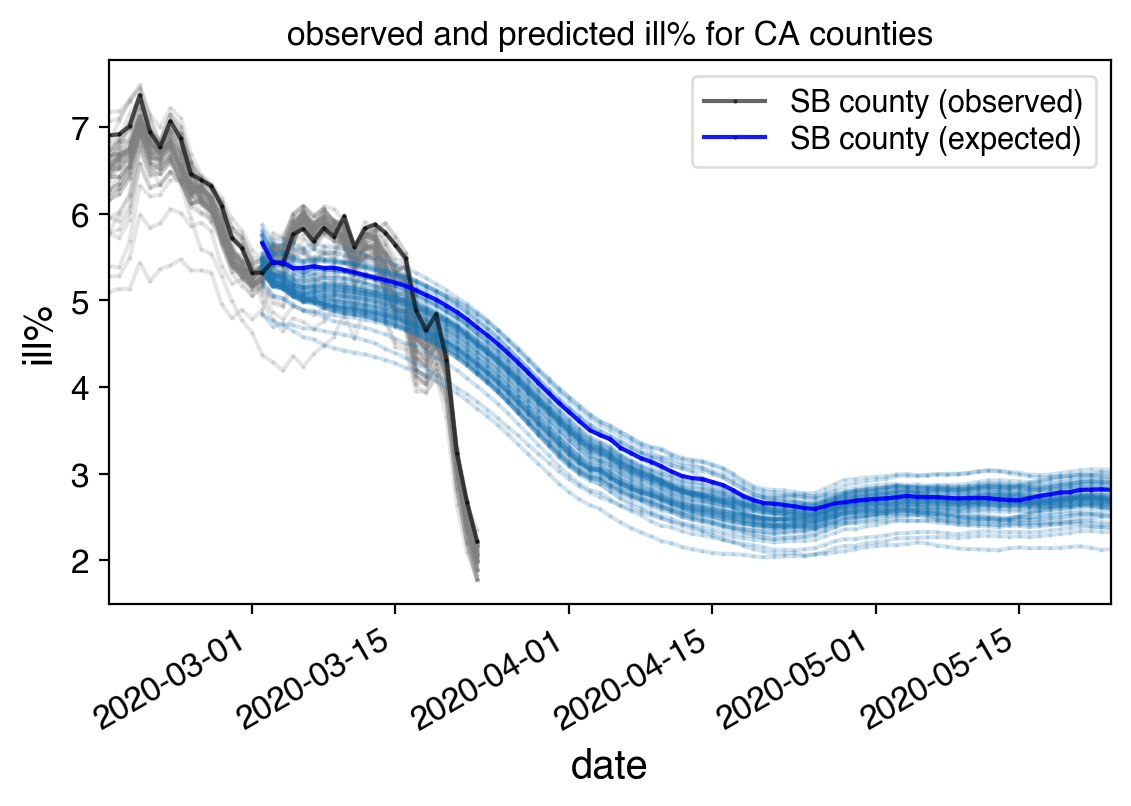

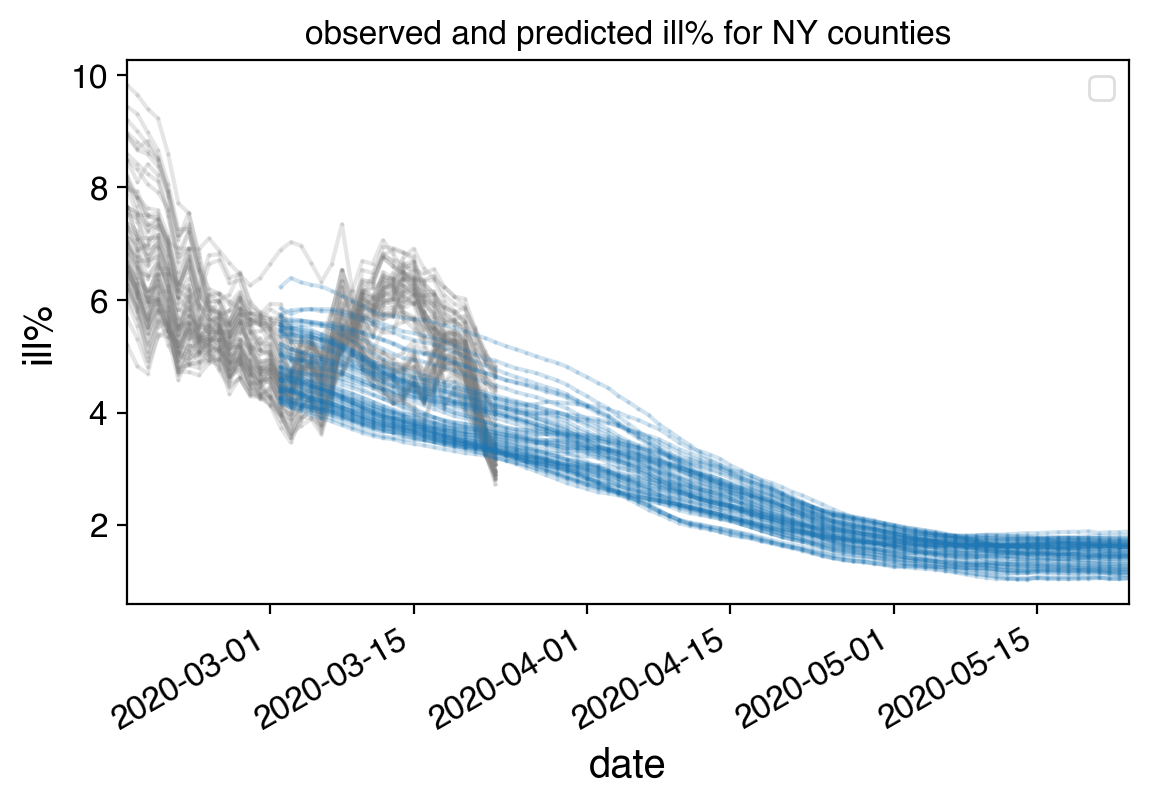

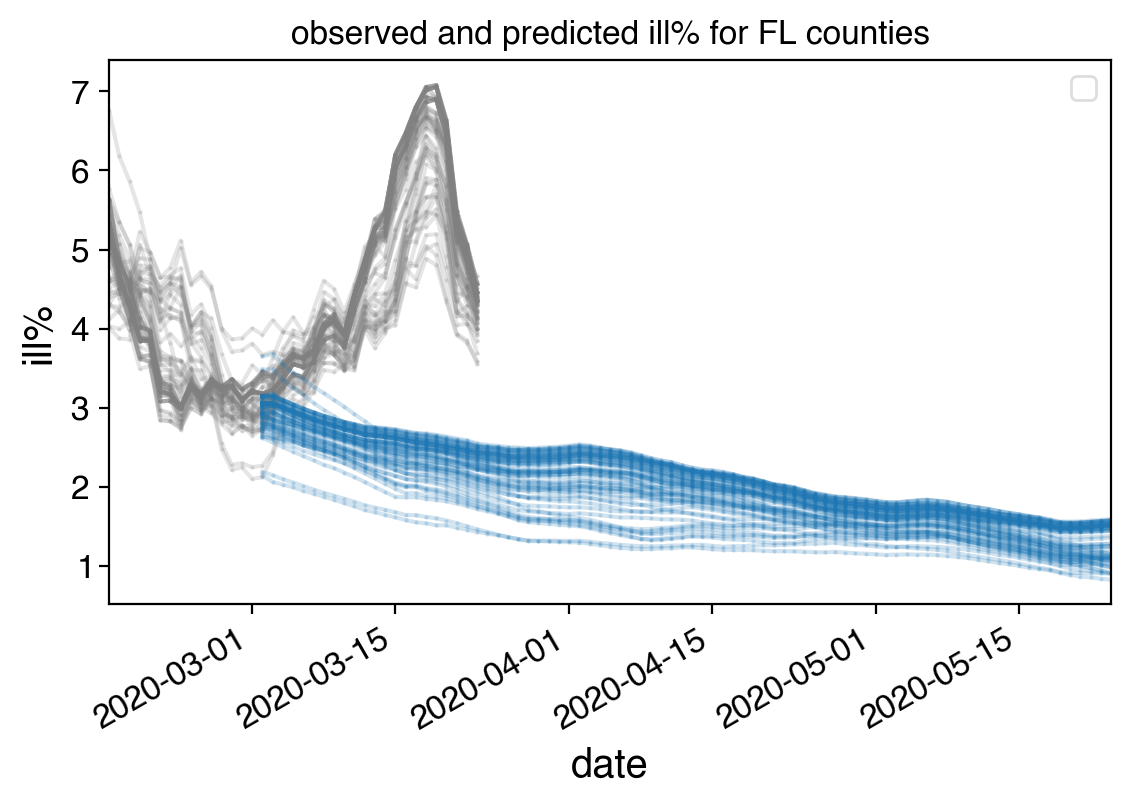

In [4]:
for state in [
    "CA", "NY", "FL",
]:

    dfc = get_df(state)

    fig, ax = plt.subplots()

    gb = dfc.groupby("region_name")
    gb["observed_ili"].plot(ax=ax, color="gray", ms=0.5, marker="o", alpha=0.2, label="");

    gb["forecast_expected"].plot(ax=ax, color="C0", ms=0.5, marker="o", alpha=0.2, label="");

    ax.legend([])

    if state == "CA":
        dfc.query("region_name=='Santa Barbara'")["observed_ili"].plot(
            ax=ax, color="black", ms=0.5, marker="o", alpha=0.6, label="SB county (observed)"
        );
        dfc.query("region_name=='Santa Barbara'")["forecast_expected"].plot(
            ax=ax, color="blue", ms=0.5, marker="o", alpha=0.9, label="SB county (expected)"
        );
        ax.legend()

    ax.set_title(f"observed and predicted ill% for {state} counties")
    ax.set_ylabel("ill%")

In [43]:
# compute a "z-score" by comparing observed to expected ill%
def calc_zscore(row):
    obs = row["observed_ili"]
    exp = row["forecast_expected"]
    up = row["forecast_upper"] - exp
    down = exp - row["forecast_lower"]
    if obs > exp: return (obs-exp)/up
    if obs < exp: return (obs-exp)/down
    
def get_zscores(dfc, days_ago=14):
    df = dfc[~dfc[["forecast_expected","observed_ili"]].isna().any(axis=1)].query(f"days_ago<{days_ago}")
    df["z"] = df.apply(calc_zscore, axis=1)
    return df.groupby("region_name")["z"].mean()
    return df["z"]

Text(0.5, 1.0, 'mean z-scores per county in CA')

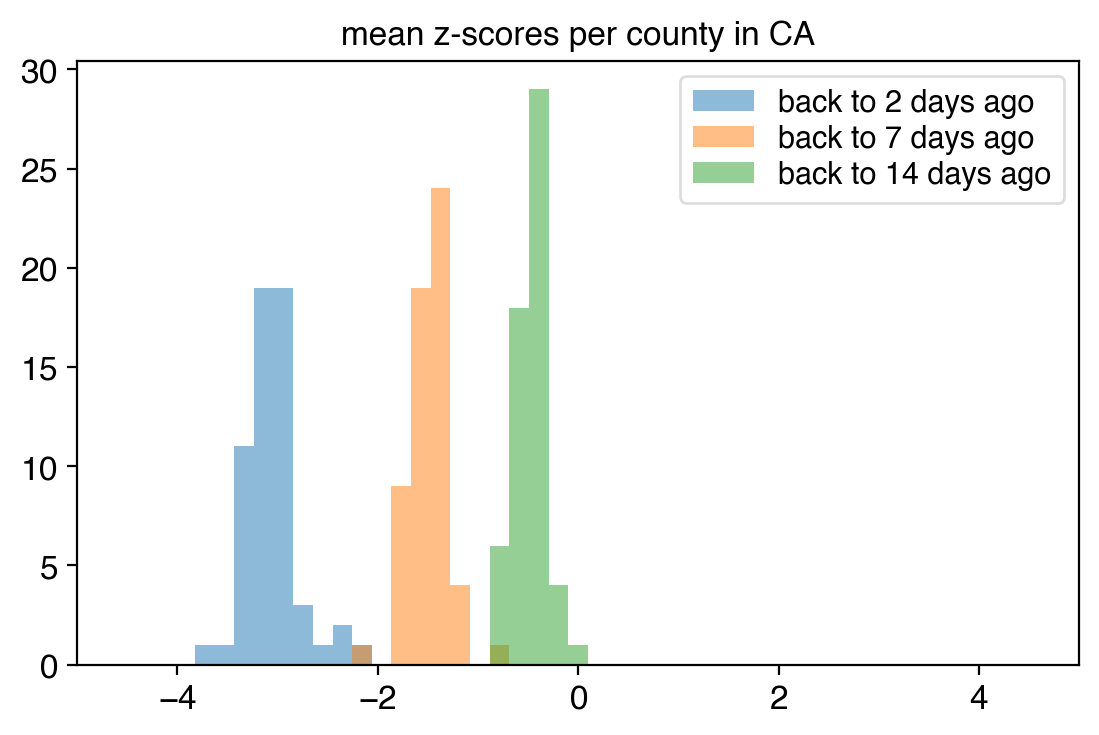

In [44]:
state = "CA"
fig, ax = plt.subplots()
for days_ago in [2,7,14]:
    Hist1D(get_zscores(get_df(state), days_ago=days_ago), bins="51,-5,5").plot(ax=ax, label=f"back to {days_ago} days ago",alpha=0.5)
ax.legend()
ax.set_title(f"mean z-scores per county in {state}")

In [45]:
df_cases_raw = pd.read_json("../sources/1point3acres/data/cases_and_deaths.json.gz").query("not is_death")
df_cases_raw["date"] = pd.to_datetime(df_cases_raw["date"])
# Require state abbreviation to be length 2 (otherwise diamond princess/etc would get included)
df_cases = df_cases_raw[df_cases_raw["state"].str.len() == 2]
df_cases = df_cases.groupby(["state","county"])[["ngroup"]].count().reset_index().rename({"ngroup":"cases"},axis=1)
print(len(df_cases))
df_cases.head()

1380


,state,county,cases
0,AK,Anchorage,17
1,AK,Fairbanks North Star,7
2,AK,Juneau,1
3,AK,Ketchikan Gateway,6
4,AK,Matanuska-Susitna Borough,2


In [46]:
dfs = []
for state in tqdm(state_abbrevs):
    df = pd.DataFrame()
    vals = get_zscores(get_df(state), days_ago=14)
    df["county"] = vals.index
    df["z"] = vals.values
    df["state"] = state
    dfs.append(df)
df_zscores = pd.concat(dfs)
print(len(df_zscores))
df_zscores.head()


3108


,county,z,state
0,Belknap,0.884100,NH
1,Carroll,0.636472,NH
2,Cheshire,1.147121,NH
3,Coos,0.717899,NH
4,Grafton,0.908916,NH


In [47]:
def fit_exp(vals):
    secs = vals.index.to_numpy().astype(int)/1e9
    secs -= secs.min()
    days = secs/86400.
    cases = vals.values

    xs, ys = days, cases

    try:
        def func(x,a=1.0,b=0.5,c=0.):
            return a*np.exp(b*(x-c))
        pars,cov = scipy.optimize.curve_fit(func,  xs,  ys)
        if pars[-1] > 100:
            def func(x,a=1.0,b=0.5):
                return a*np.exp(b*x)
            pars,cov = scipy.optimize.curve_fit(func,  xs,  ys)
    except:
#         print("FAILED!",vals)
        return dict()
        
    ypred = func(xs, *pars)
    td = (pars[1]*np.log(np.exp(1))/np.log(2))**-1.0
    return dict(xs=xs, ys=ys, ypred=ypred, pars=pars, cov=cov, td=td)


In [48]:
len(df_cases_raw.groupby(["state","county"]))

1389

In [49]:
data = []
gb = df_cases_raw.groupby(["state","county"])
for i,(name,group) in enumerate(gb):
    vals = group.groupby("date")["ngroup"].count().cumsum()
    ret = fit_exp(vals)
    if not ret: 
        continue
    state, county = name
    td = ret["td"]
    data.append(dict(state=state, county=county, td=td))
df_tds = pd.DataFrame(data)
print(len(df_tds))
df_tds.head()

/Users/namin/Library/Python/3.7/lib/python/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/namin/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/Users/namin/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


655


,state,county,td
0,AK,Anchorage,1.756066
1,AK,Fairbanks North Star,3.114567
2,AK,Ketchikan Gateway,1.247104
3,AL,Baldwin,4.588680
4,AL,Chambers,1.857599


In [50]:
df_both = df_zscores.merge(df_cases, how="left", on=["state","county"]).fillna(0)
df_both = df_both.merge(df_tds, how="left", on=["state","county"]).fillna(0)
print(len(df_both))
df_both.head()

3108


,county,z,state,cases,td
0,Belknap,0.884100,NH,0.0,0.000000
1,Carroll,0.636472,NH,7.0,4.201912
2,Cheshire,1.147121,NH,1.0,0.000000
3,Coos,0.717899,NH,0.0,0.000000
4,Grafton,0.908916,NH,20.0,3.887149


In [55]:
df = df_both.query("cases>2")
x = np.log10(df["cases"])
y = df["z"]
slope, intercept, rval, pval, _ = scipy.stats.linregress(x, y)
rsq = rval**0.5
label = rf"$r^2$={rsq:.2f}"
print(label)

$r^2$=0.48


Text(0.5, 1.0, 'per county z-scores (from healthweather.us) vs covid19 cases')

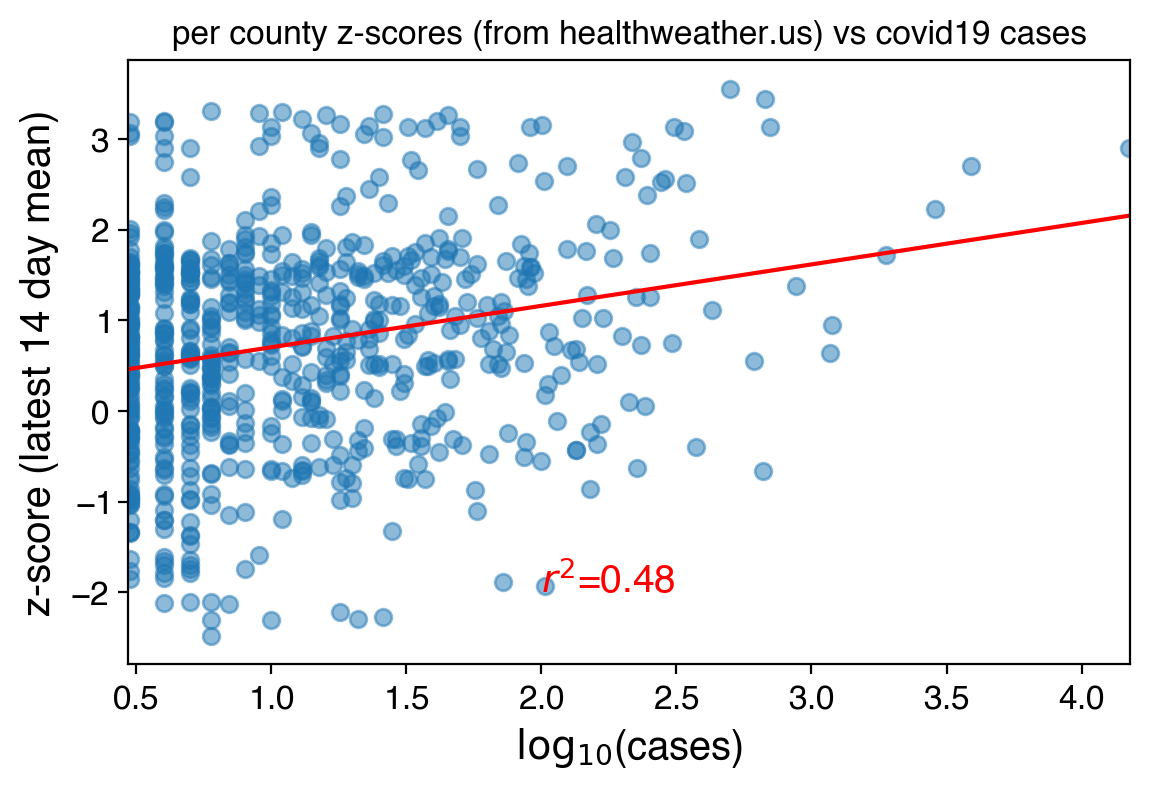

In [56]:
fig, ax = plt.subplots()
ax.scatter(x, y, marker="o", alpha=0.5)

xs = np.linspace(*ax.get_xlim(), 100)
ys = slope*xs + intercept
ax.plot(xs,ys, color="red")

ax.text(2, -2., label, color="red", fontsize=14)
ax.set_xlabel(r"$\mathrm{log}_{10}$(cases)")
ax.set_ylabel("z-score (latest 14 day mean)")

ax.set_title("per county z-scores (from healthweather.us) vs covid19 cases")

Text(0.5, 0, 'doubling time (days)')

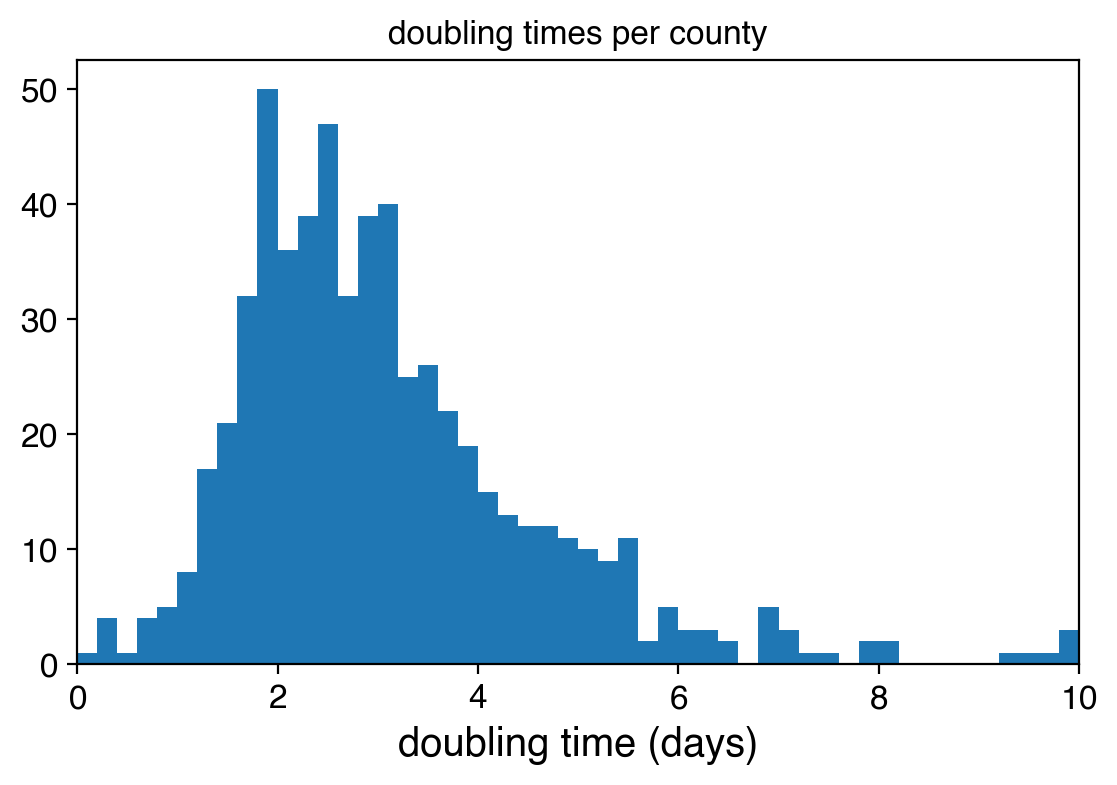

In [58]:
fig, ax = plt.subplots()
Hist1D(df_both.query("td>0")["td"], bins="50,0,10").plot(ax=ax)
ax.set_title("doubling times per county")
ax.set_xlabel("doubling time (days)")

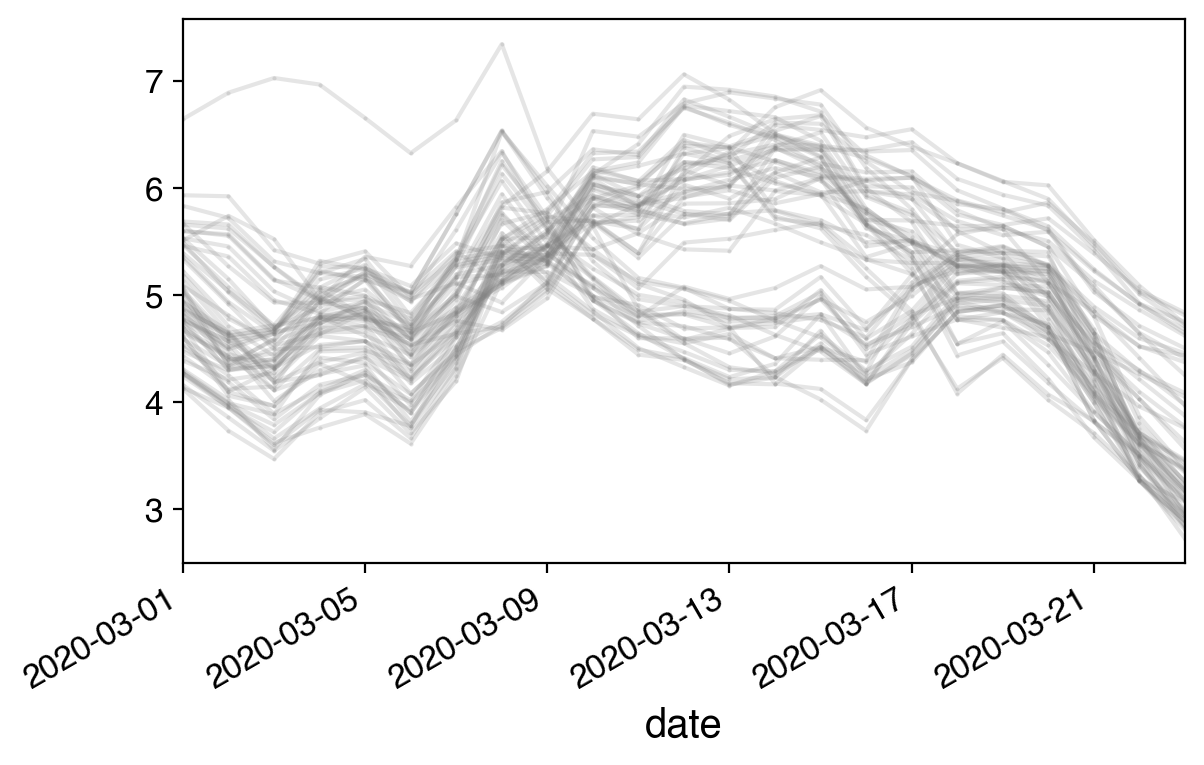

In [28]:
# Weird. NY has two different trends. Try to separate them into top (>5.3) and bottom (<5.3) based on 03-15-20 data.
# top and bottom not necessarily from geography, just from the position in the plot.

dfc = get_df("NY")

fig, ax = plt.subplots()

gb = dfc.loc["2020-03-01":"2020-03-23"].groupby("region_name")
gb["observed_ili"].plot(ax=ax, color="gray", ms=0.5, marker="o", alpha=0.2, label="");

top = dfc.loc["2020-03-15"].query("observed_ili > 5.3")[["region_name","state"]].rename({"region_name":"county"},axis=1).copy()
bot = dfc.loc["2020-03-15"].query("observed_ili < 5.3")[["region_name","state"]].rename({"region_name":"county"},axis=1).copy()


In [22]:
top.head()

,county,state
date,,
2020-03-15,Albany,NY
2020-03-15,Bronx,NY
2020-03-15,Chenango,NY
2020-03-15,Clinton,NY
2020-03-15,Columbia,NY


In [23]:
bot.head()

,county,state
date,,
2020-03-15,Allegany,NY
2020-03-15,Broome,NY
2020-03-15,Cattaraugus,NY
2020-03-15,Cayuga,NY
2020-03-15,Chautauqua,NY


Text(0.5, 1.0, 'log10(cases) for two separate clusters of NY counties')

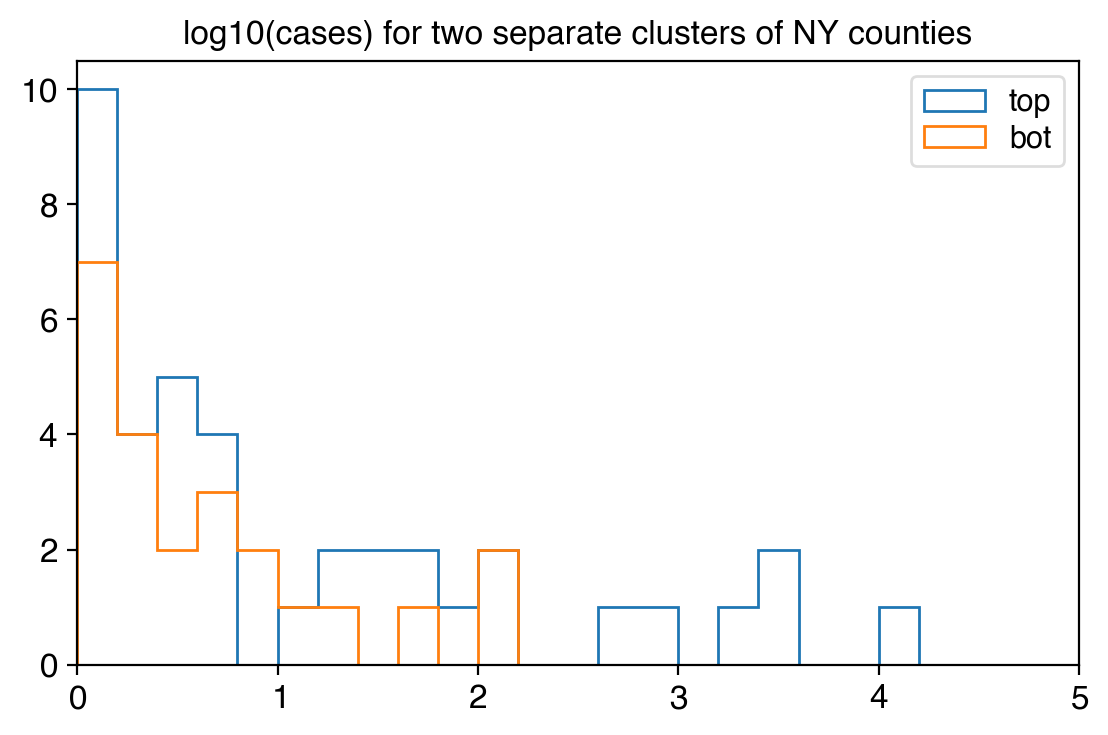

In [25]:
htop = Hist1D(
    np.log10(top.merge(df_both, on=["county", "state"])["cases"]),
    bins="25,0,5",
)
hbot = Hist1D(
    np.log10(bot.merge(df_both, on=["county", "state"])["cases"]),
    bins="25,0,5",
)
fig, ax = plt.subplots()
htop.plot(ax=ax,histtype="step", label="top")
hbot.plot(ax=ax,histtype="step", label="bot")
ax.legend()
ax.set_title("log10(cases) for two separate clusters of NY counties")